# Project 1


#### `Libraries`


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

#### Solvers


1. Gauss Elimination


In [2]:
def GaussElimination(A, b):
    """Function that solves gauss elimination by elementary row operations.
    
    Keyword arguments:
    A - torch.Tensor(): matrix
    b - torch.Tensor(): vector
    Return: x -> solution vector
    """
    
    n = A.shape[0]
    
    # Forward Elimination
    for i in range(n-1):
        for j in range(i+1, n):
            factor = A[j, i] / A[i, i]
            A[j, i:] -= factor * A[i, i:]
            b[j] -= factor * b[i]

    # Back Substitution
    x = torch.zeros_like(b)

    for i in reversed(range(n-1)):
        s = torch.dot(A[i, i+1:], x[i+1:])
        x[i] = (b[i] - s) / A[i, i]

    return x


2. TDMA solver


In [18]:
def TDMA(a, b, c, d):
    n = len(d)
    cp = torch.zeros(n, device=device)
    dp = torch.zeros(n, device=device)

    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]

    for i in range(1, n):
        denom = b[i] - a[i] * cp[i - 1]
        cp[i] = c[i] / denom
        dp[i] = (d[i] - a[i] * dp[i - 1]) / denom

    x = torch.zeros(n, device=device)
    x[-1] = dp[-1]
    for i in range(n - 2, -1, -1):
        x[i] = dp[i] - cp[i] * x[i + 1]

    return x


#### Plotters


In [42]:
def field_plotter(contour_vals):
    X = contour_vals[0].cpu().numpy()
    Y = contour_vals[1].cpu().numpy()
    Z = contour_vals[2].reshape(N,N).cpu().numpy()
    X, Y = np.meshgrid(X,Y)
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, Z, cmap='jet', levels=50)
    plt.colorbar(contour, label='Phi')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Contour Plot {contour_vals[3]} X {contour_vals[3]} grid')
    plt.show()

In [ ]:
def CPU_Time(input_size, runtimes):
    plt.figure(figsize=(10, 6))
    input_sizes = [i**2 for i in input_size]
    plt.plot(input_sizes, runtimes, marker='o', linestyle='-', color='b')
    plt.xlabel('Input Size')
    plt.ylabel('CPU Runtime (seconds)')
    plt.title('CPU Runtime vs Input Size')
    plt.grid(True)
    plt.show()

In [6]:
def itterVsResidual(iterations, residuals):
    plt.figure(figsize=(8, 6))
    
    for i, res in enumerate(residuals):
        plt.plot(iterations[i], res, label=f'Residuals for Mesh {i+1}')
    
    plt.xlabel('Iterations')
    plt.ylabel('Residual')
    plt.title('Iterations vs Residuals')
    plt.grid(True)
    plt.legend()
    plt.show()



##### Boundry Conditions and Source Term


In [23]:
phi_left = lambda y: 500 * torch.exp(-50 * (1 + y**2))
phi_right = lambda y: 100 * (1 - y) + 500 * torch.exp(-50 * y**2)
phi_bottom = lambda x: 100 * x + 500 * torch.exp(-50 * (1 - x)**2)
phi_top = lambda x: 500 * torch.exp(-50 * ((1 - x)**2 + 1))

source_term = lambda x, y: 50000 * torch.exp(-50 * ((1 - x) ** 2 + y ** 2)) * (100 * ((1 - x) ** 2 + y ** 2) - 2)


##### Generalized equation


In [37]:
def Matrix_Generation(N):
    dx, dy = 1.0 / (N - 1), 1.0/ (N - 1)

    A = torch.zeros((N * N, N * N), device='cuda')
    b = torch.zeros(N * N, device='cuda')
    x = torch.linspace(0, 1, N, device='cuda')
    y = torch.linspace(0, 1, N, device='cuda')

    for j in range(N):
        for i in range(N):
            index = j*N + i
            
            if i == 0:
                A[index, index] = 1
                b[index] = phi_left(y[j])
            elif i == N-1:
                A[index, index] = 1
                b[index] = phi_right(y[j])
            elif j == 0:
                A[index, index] = 1
                b[index] = phi_bottom(x[i])
            elif j == N-1:
                A[index, index] = 1
                b[index] = phi_top(x[i])
            else:
                A[index, index] = -2/dx**2 - 2/dy**2
                A[index, index-1] = 1/dx**2
                A[index, index+1] = 1/dx**2
                A[index, index-N] = 1/dy**2
                A[index, index+N] = 1/dy**2
                b[index] = source_term(x[i], y[j])

    return A, b, x, y


## Solution using Gauss Elimination


In [38]:
grid_points = [21,41,81]
runtimes_GE = []
contour_vals_GE = []

for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    A,b,x,y = Matrix_Generation(N)
    phi = GaussElimination(A,b)
    end = time.time()
    contour_vals_GE.append((x,y,phi,N))
    runtimes_GE.append(end-start)


In [39]:
runtimes_GE

[8.887625694274902, 127.50359034538269, 1937.398604631424]

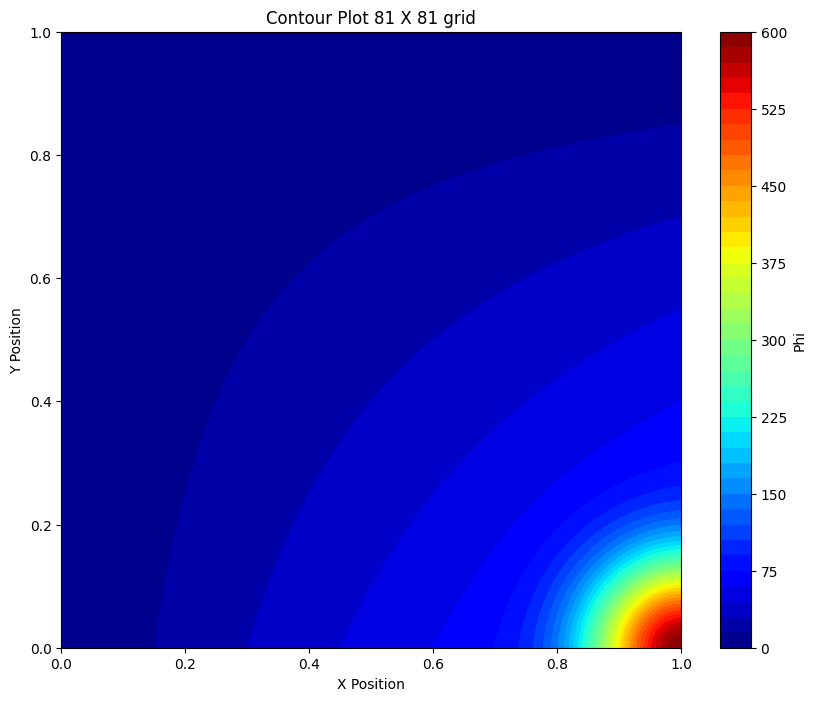

In [43]:
field_plotter(contour_vals_GE[2])

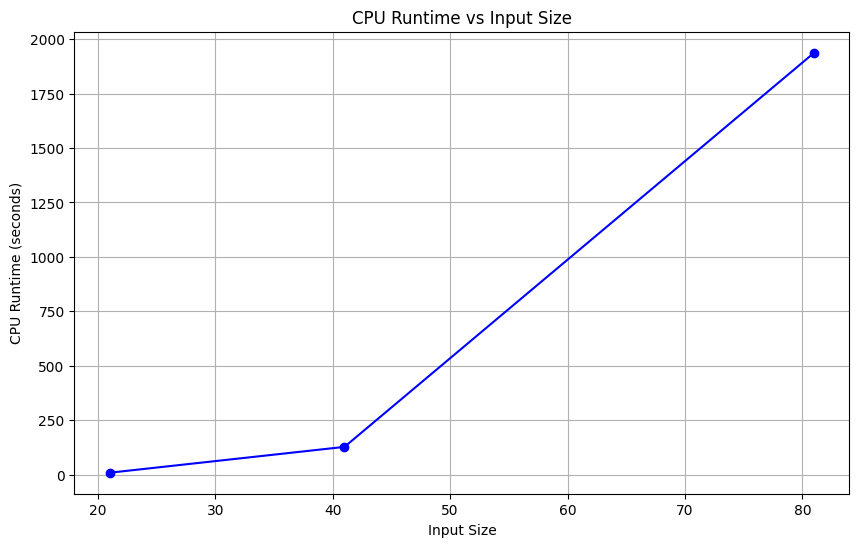

In [44]:
CPU_Time([21,41,81], runtimes_GE)

## Solution using Gauss Siedel Itterative Method


In [100]:
def GaussSeidel(Nx, Ny, tol=1e-3):
    itter_ = 0
    phi = torch.zeros((Nx, Ny), device='cuda')
    residuals = []
    dx, dy = 1 / (Nx - 1), 1 / (Ny - 1)
    x = torch.linspace(0, 1, Nx, device="cuda")
    y = torch.linspace(0, 1, Ny, device="cuda")
    
    # using boundry conditions
    
    phi[:, 0] = 100 * x + 500 * torch.exp(-50 * (1 - x) ** 2)
    phi[:, -1] = 500 * torch.exp(-50 * ((1 - x) ** 2 + 1))
    phi[0, :] = 500 * torch.exp(-50 * (1 + y ** 2))
    phi[-1, :] = 100 * (1 - y) + 500 * torch.exp(-50 * y ** 2)
    
    X, Y = torch.meshgrid(x, y)
    S_phi = 50000 * torch.exp(-50 * ((1 - X) ** 2 + Y ** 2)) * (100 * ((1 - X) ** 2 + Y ** 2) - 2)


    while True:
        itter_+=1
        phi_old = phi.clone()
        
        for i in range(1, Nx - 1):
            for j in range(1, Ny - 1):
                phi[i, j] = 0.25 * ((phi[i+1, j] + phi[i-1, j] + phi[i, j+1] + phi[i, j-1]) - (dx * dy * S_phi[i, j]))

        residual = torch.norm(phi - phi_old)
        residuals.append(residual.item())
        print(residual)
        if residual / max(residuals) < tol:
            break

    return phi, residuals, itter_, x, y

In [ ]:
grid_points = [41,81,161]
runtimes_GS = []
contour_vals_GS = []
itterations = []
residuals_GS = []

for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    phi, residuals,itter_,x,y = GaussSeidel(N,N)
    end = time.time()
    contour_vals_GS.append((x,y,phi,N))
    runtimes_GS.append(end-start)
    residuals_GS.append(residuals)
    itterations.append(itter_)

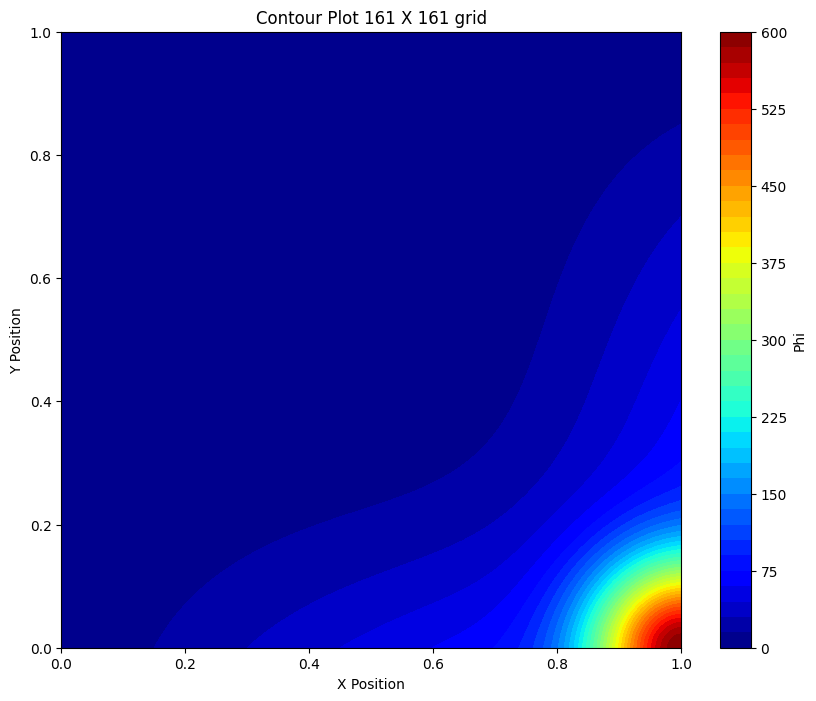

In [102]:
field_plotter(contour_vals_GS[2])

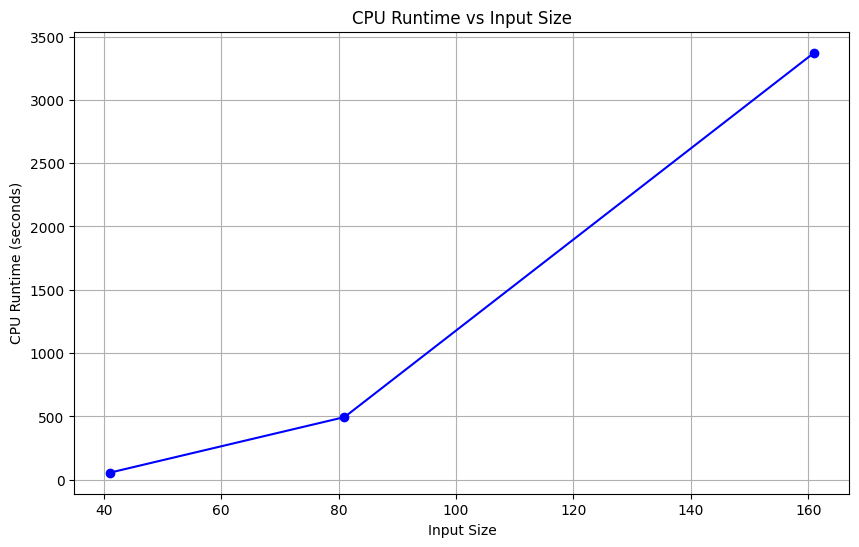

In [103]:
CPU_Time([41,81,161], runtimes_GS)

In [110]:
itterations_GS_Final = [[x for x in range(1, i+1)] for i in itterations]

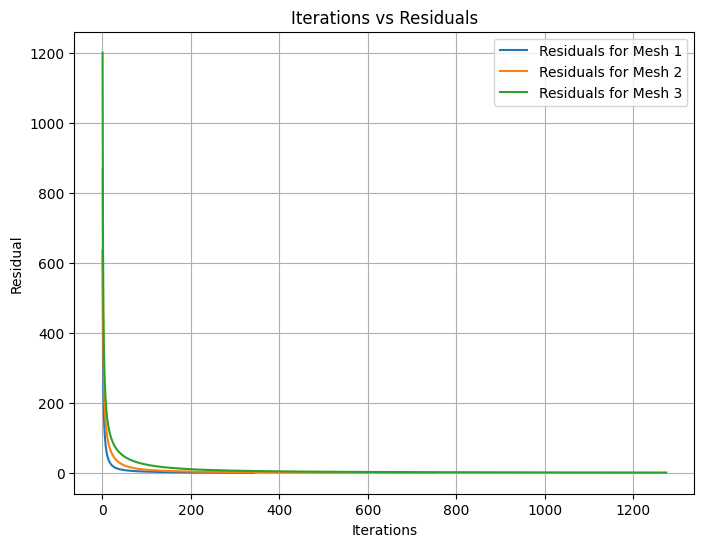

In [112]:
itterVsResidual(itterations_GS_Final, residuals_GS)

## Solution using Gauss Siedel [Line By Line] Itterative Method


In [55]:
def LineByLine_RowSweep(Nx, Ny, tol=1e-3):
    dx, dy = 1 / (Nx - 1), 1 / (Ny - 1)
    phi = torch.zeros((Nx, Ny), device="cuda")
    x = torch.linspace(0, 1, Nx, device="cuda")
    y = torch.linspace(0, 1, Ny, device="cuda")
    residuals=[]
    itter_ = 0

    # Boundary conditions
    phi[:, 0] = 100 * x + 500 * torch.exp(-50 * (1 - x) ** 2)
    phi[:, -1] = 500 * torch.exp(-50 * ((1 - x) ** 2 + 1))
    phi[0, :] = 500 * torch.exp(-50 * (1 + y ** 2))
    phi[-1, :] = 100 * (1 - y) + 500 * torch.exp(-50 * y ** 2)
    
    X, Y = torch.meshgrid(x, y)
    S_phi = 50000 * torch.exp(-50 * ((1 - X) ** 2 + Y ** 2)) * (100 * ((1 - X) ** 2 + Y ** 2) - 2)
    
    while True:
        itter_+=1
        phi_old = phi.clone()

        for j in range(1, Ny - 1):
            a = -torch.ones(Nx - 2, device="cuda") / dx**2
            b = 2 * (1 / dx**2 + 1 / dy**2) * torch.ones(Nx - 2, device="cuda")
            c = -torch.ones(Nx - 2, device="cuda") / dx**2
            d = -S_phi[1:-1, j] + (phi[1:-1, j+1] + phi[1:-1, j-1]) / dy**2

            phi[1:-1, j] = TDMA(a, b, c, d)

        residual = torch.norm(phi - phi_old)
        residuals.append(residual.item())
        print(residual)
        if residual / max(residuals) < tol:
            break

    return phi, residuals, itter_x,y
            
    

In [61]:
grid_points = [41,81,161]
runtimes_RS = []
contour_vals_RS = []
itterations_RS = []
residuals_RS = []
for N in grid_points:
    print(f"Running for grid size: {N} x {N}")
    start = time.time()
    phi, residuals,itter_,x,y = LineByLine_RowSweep(N,N)
    end = time.time()
    contour_vals_RS.append((x,y,phi,N))
    runtimes_RS.append(end-start)
    residuals_RS.append(residuals)
    itterations_RS.append(itter_)

tensor(2.7452, device='cuda:0')
tensor(2.7292, device='cuda:0')
tensor(2.7134, device='cuda:0')
tensor(2.6977, device='cuda:0')
tensor(2.6821, device='cuda:0')
tensor(2.6668, device='cuda:0')
tensor(2.6516, device='cuda:0')
tensor(2.6365, device='cuda:0')
tensor(2.6216, device='cuda:0')
tensor(2.6069, device='cuda:0')
tensor(2.5923, device='cuda:0')
tensor(2.5779, device='cuda:0')
tensor(2.5636, device='cuda:0')
tensor(2.5495, device='cuda:0')
tensor(2.5355, device='cuda:0')
tensor(2.5217, device='cuda:0')
tensor(2.5079, device='cuda:0')
tensor(2.4944, device='cuda:0')
tensor(2.4809, device='cuda:0')
tensor(2.4676, device='cuda:0')
tensor(2.4545, device='cuda:0')
tensor(2.4414, device='cuda:0')
tensor(2.4285, device='cuda:0')
tensor(2.4157, device='cuda:0')
tensor(2.4031, device='cuda:0')
tensor(2.3905, device='cuda:0')
tensor(2.3781, device='cuda:0')
tensor(2.3658, device='cuda:0')
tensor(2.3537, device='cuda:0')
tensor(2.3416, device='cuda:0')
tensor(2.3297, device='cuda:0')
tensor(2

In [62]:
len(contour_vals_RS)

3

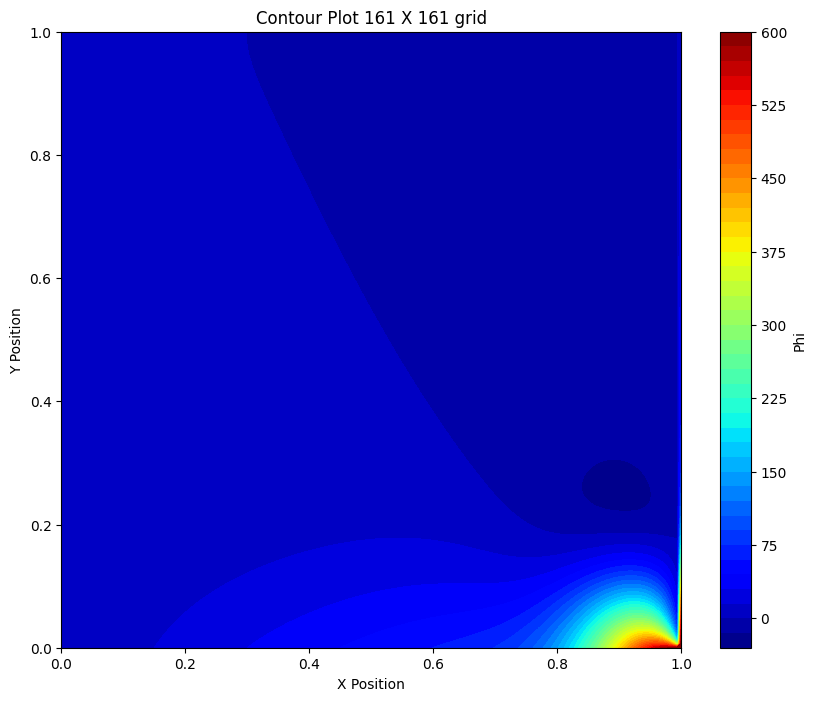

In [64]:
field_plotter(contour_vals_RS[2])

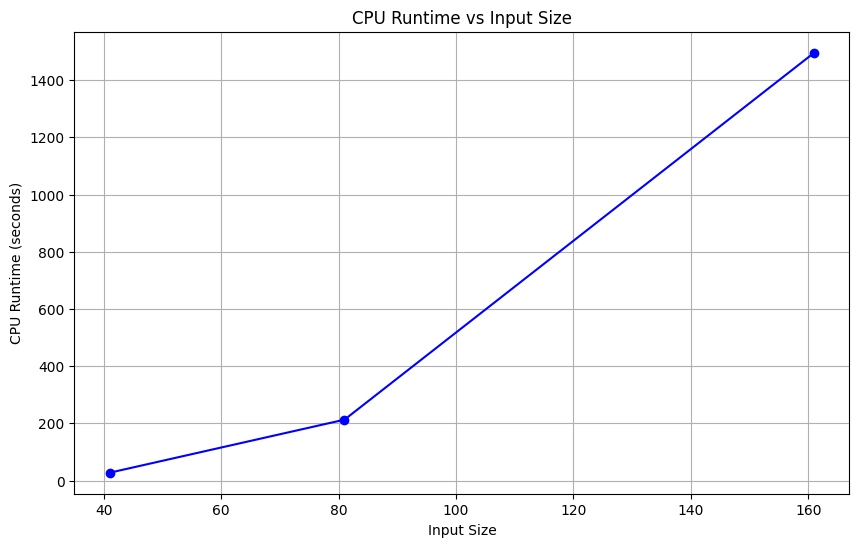

In [65]:
CPU_Time([41,81,161], runtimes_RS)

In [72]:
itterations_RS_final = [120, 232, 408]

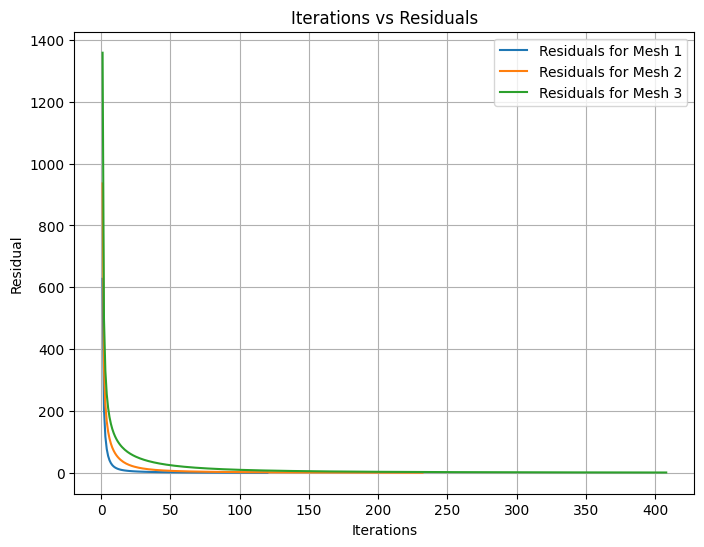

In [79]:
itterVsResidual(itterations_RS, residuals_RS)

## Solution using ADI method


In [30]:
Lx, Ly = 1.0, 1.0
nx, ny = 41, 81
dx = Lx / (nx - 1)
dy = Ly / (ny - 1)
max_iter = 10000
tolerance = 1e-3
residuals = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Boundary conditions
def phi_bc(x, y, side):
    if side == 'left':
        return 500 * torch.exp(-50 * (1 + y ** 2))
    elif side == 'right':
        return 100 * (1 - y) + 500 * torch.exp(-50 * y ** 2)
    elif side == 'bottom':
        return 100 * x + 500 * torch.exp(-50 * (1 - x) ** 2)
    elif side == 'top':
        return 500 * torch.exp(-50 * ((1 - x) ** 2 + 1))

phi = torch.zeros((ny, nx), device=device)
x = torch.linspace(0, Lx, nx, device=device)
y = torch.linspace(0, Ly, ny, device=device)

for j in range(ny):
    phi[j, 0] = phi_bc(0, y[j], 'left')
    phi[j, -1] = phi_bc(1, y[j], 'right')

for i in range(nx):
    phi[0, i] = phi_bc(x[i], 0, 'bottom')
    phi[-1, i] = phi_bc(x[i], 1, 'top')

for iteration in range(max_iter):
    phi_old = phi.clone()

    # Row-wise sweep (x-direction)
    for j in range(1, ny-1):
        a = torch.ones(nx-2, device=device) / dx**2
        b = -2 * (1/dx**2 + 1/dy**2) * torch.ones(nx-2, device=device)
        c = torch.ones(nx-2, device=device) / dx**2
        d = -source_term(x[1:-1], y[j])

        d -= (phi[j+1, 1:-1] + phi[j-1, 1:-1]) / dy**2

        phi[j, 1:-1] = TDMA(a, b, c, d)

    for i in range(1, nx-1):
        a = torch.ones(ny-2, device=device) / dy**2
        b = -2 * (1/dx**2 + 1/dy**2) * torch.ones(ny-2, device=device)
        c = torch.ones(ny-2, device=device) / dy**2
        d = -source_term(x[i], y[1:-1])

        d -= (phi[1:-1, i+1] + phi[1:-1, i-1]) / dx**2

        phi[1:-1, i] = TDMA(a, b, c, d)

    residual = torch.norm(phi - phi_old)
    residuals.append(residual)
    print(residual)
    if residual/max(residuals) < tolerance:
        break


tensor(5.4333, device='cuda:0')
tensor(5.3441, device='cuda:0')
tensor(5.2568, device='cuda:0')
tensor(5.1711, device='cuda:0')
tensor(5.0872, device='cuda:0')
tensor(5.0048, device='cuda:0')
tensor(4.9241, device='cuda:0')
tensor(4.8449, device='cuda:0')
tensor(4.7671, device='cuda:0')
tensor(4.6909, device='cuda:0')
tensor(4.6160, device='cuda:0')
tensor(4.5425, device='cuda:0')
tensor(4.4704, device='cuda:0')
tensor(4.3996, device='cuda:0')
tensor(4.3300, device='cuda:0')
tensor(4.2617, device='cuda:0')
tensor(4.1945, device='cuda:0')
tensor(4.1286, device='cuda:0')
tensor(4.0638, device='cuda:0')
tensor(4.0001, device='cuda:0')
tensor(3.9376, device='cuda:0')
tensor(3.8761, device='cuda:0')
tensor(3.8156, device='cuda:0')
tensor(3.7562, device='cuda:0')
tensor(3.6978, device='cuda:0')
tensor(3.6403, device='cuda:0')
tensor(3.5838, device='cuda:0')
tensor(3.5283, device='cuda:0')
tensor(3.4737, device='cuda:0')
tensor(3.4199, device='cuda:0')
tensor(3.3671, device='cuda:0')
tensor(3

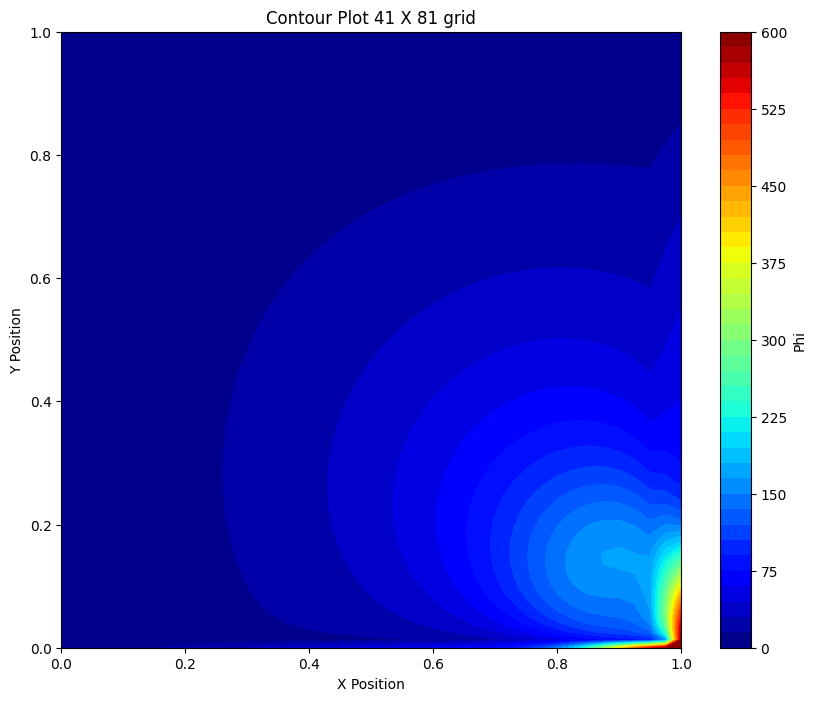

In [34]:
X = x.cpu().numpy()
Y = y.cpu().numpy()
Z = phi.cpu().numpy()
X, Y = np.meshgrid(X,Y)
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, cmap='jet', levels=50)
plt.colorbar(contour, label='Phi')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title(f'Contour Plot 41 X 81 grid')
plt.show()